## Monolingual Named Entity Recognition (Few Nerd Dataset) (Evaluated Locally)

Dataset Source: https://huggingface.co/datasets/DFKI-SLT/few-nerd

#### Install Necessary Libraries

In [1]:
%pip install transformers datasets evaluate seqeval
%pip install accelerate -U

You should consider upgrading via the '/Users/briandunn/Desktop/python_venvs/torch_cv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/briandunn/Desktop/python_venvs/torch_cv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


#### HuggingFace Access

In [2]:
#!huggingface-cli login

#### Import Necessary Libraries

In [3]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datasets
from datasets import load_dataset, DatasetDict
from datasets import Dataset, concatenate_datasets

import torch
from torch.nn.functional import cross_entropy

import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [4]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)

          Python : 3.9.12
           NumPy : 1.25.1
          Pandas : 2.0.3
           Torch : 2.0.1
    Transformers : 4.28.1
        Datasets : 2.13.1
        Evaluate : 0.4.0
         Sklearn : 1.3.0


#### Ingest English Subset of Dataset

In [5]:
subsets_to_include = ["inter",
                      "intra",
                      "supervised",
                      ]

temp_data: []
train_data: Dataset
test_data: Dataset
eval_data: Dataset

for idx, s in enumerate(subsets_to_include):
    temp_data = load_dataset("DFKI-SLT/few-nerd", s)
    if idx != 0:
        train_data = concatenate_datasets([temp_data['train'], train_data])
        test_data = concatenate_datasets([temp_data['test'], test_data])
        eval_data = concatenate_datasets([temp_data['validation'], eval_data])
    else:
        train_data = temp_data['train']
        test_data = temp_data['test']
        eval_data = temp_data['validation']

print(f"Training Dataset Information: \n{train_data}")
print(f"Testing Dataset Information: \n{test_data}")
print(f"Evaluation Dataset Information: \n{eval_data}")

Found cached dataset few-nerd (/Users/briandunn/.cache/huggingface/datasets/DFKI-SLT___few-nerd/inter/0.0.0/c4e2bba21055a1e5f9d70b1ede49778c6ef267f3a6240d54f12e43f72fce5dd4)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset few-nerd (/Users/briandunn/.cache/huggingface/datasets/DFKI-SLT___few-nerd/intra/0.0.0/c4e2bba21055a1e5f9d70b1ede49778c6ef267f3a6240d54f12e43f72fce5dd4)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset few-nerd (/Users/briandunn/.cache/huggingface/datasets/DFKI-SLT___few-nerd/supervised/0.0.0/c4e2bba21055a1e5f9d70b1ede49778c6ef267f3a6240d54f12e43f72fce5dd4)


  0%|          | 0/3 [00:00<?, ?it/s]

Training Dataset Information: 
Dataset({
    features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
    num_rows: 361398
})
Testing Dataset Information: 
Dataset({
    features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
    num_rows: 95714
})
Evaluation Dataset Information: 
Dataset({
    features: ['id', 'tokens', 'ner_tags', 'fine_ner_tags'],
    num_rows: 56999
})


#### Split Dataset into DatasetDict

In [6]:
# Pack all of them into DatasetDict

ds = DatasetDict({
    'train': train_data,
    'test': test_data,
    'eval': eval_data})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Validation data shape:', ds['eval'].shape)

Training data shape: (361398, 4)
Testing data shape: (95714, 4)
Validation data shape: (56999, 4)


#### Example

In [7]:
example = ds['eval'][12]

example

{'id': '12',
 'tokens': ['Launched',
  'in',
  '1996',
  ',',
  'the',
  '3000',
  'was',
  'developed',
  'from',
  'the',
  'Laser',
  '2',
  ',',
  'using',
  'the',
  'original',
  'Frank',
  'Bethwaite',
  '-designed',
  'planing',
  'hull',
  'combined',
  'with',
  'a',
  'brand',
  'new',
  'self-draining',
  'deck',
  'by',
  'Derek',
  'Clark',
  '.'],
 'ner_tags': [0,
  0,
  0,
  0,
  0,
  8,
  0,
  0,
  0,
  0,
  8,
  8,
  0,
  0,
  0,
  0,
  7,
  7,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  7,
  7,
  0],
 'fine_ner_tags': [0,
  0,
  0,
  0,
  0,
  63,
  0,
  0,
  0,
  0,
  63,
  63,
  0,
  0,
  0,
  0,
  54,
  54,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  54,
  54,
  0]}

#### Display Feature Information About Each Feature

In [8]:
for k, v in ds["eval"].features.items():
    print(f"{k}: \n{v}\n")

id: 
Value(dtype='string', id=None)

tokens: 
Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

ner_tags: 
Sequence(feature=ClassLabel(names=['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product'], id=None), length=-1, id=None)

fine_ner_tags: 
Sequence(feature=ClassLabel(names=['O', 'art-broadcastprogram', 'art-film', 'art-music', 'art-other', 'art-painting', 'art-writtenart', 'building-airport', 'building-hospital', 'building-hotel', 'building-library', 'building-other', 'building-restaurant', 'building-sportsfacility', 'building-theater', 'event-attack/battle/war/militaryconflict', 'event-disaster', 'event-election', 'event-other', 'event-protest', 'event-sportsevent', 'location-GPE', 'location-bodiesofwater', 'location-island', 'location-mountain', 'location-other', 'location-park', 'location-road/railway/highway/transit', 'organization-company', 'organization-education', 'organization-government/governmentagency', 'organizati

#### Define Tag Values & Conversions Between String & Integer Values

In [9]:
label2id ={
    "O": 0,
    "art": 1,
    "building": 2,
    "event": 3,
    "location": 4,
    "organization": 5,
    "other": 6,
    "person": 7,
    "product": 8
    }

tag_values = list(label2id.keys())
NUM_OF_LABELS = len(tag_values)

id2label = {tag: idx for idx, tag in label2id.items()}

print(f"List of tag values: \n{tag_values}")
print(f"Number of NER Tags: \n{NUM_OF_LABELS}")
print(f"id2label: \n{id2label}")
print(f"label2id: \n{label2id}")

List of tag values: 
['O', 'art', 'building', 'event', 'location', 'organization', 'other', 'person', 'product']
Number of NER Tags: 
9
id2label: 
{0: 'O', 1: 'art', 2: 'building', 3: 'event', 4: 'location', 5: 'organization', 6: 'other', 7: 'person', 8: 'product'}
label2id: 
{'O': 0, 'art': 1, 'building': 2, 'event': 3, 'location': 4, 'organization': 5, 'other': 6, 'person': 7, 'product': 8}


#### Basic Values/Constants

In [10]:
MODEL_CKPT = "bert-base-cased"

MODEL_NAME = f"{MODEL_CKPT}-finetuned-ner-DFKI-SLT_few-NERd"
NUM_OF_EPOCHS = 2

BATCH_SIZE = 16
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
WEIGHT_DECAY = 0.01

LR = 2e-5
DEVICE = torch.device("cpu")

STEPS = 1200

#### Function to Tokenize & Align Inputs

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_and_align_labels(samples):
    tokenized_inputs = tokenizer(samples["tokens"],
                                      truncation=True,
                                      is_split_into_words=True)

    labels = []

    for idx, label in enumerate(samples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        prev_word_idx = None
        label_ids = []
        for word_idx in word_ids: # set special tokens to -100
            if word_idx is None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

#### Apply Above Function to Tokenize Dataset

In [12]:
encoded_ds = ds.map(tokenize_and_align_labels,
                       batched=True,
                       remove_columns=
                        [
                            'ner_tags',
                            'tokens'
                        ]
                    )

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/DFKI-SLT___few-nerd/supervised/0.0.0/c4e2bba21055a1e5f9d70b1ede49778c6ef267f3a6240d54f12e43f72fce5dd4/cache-e6d3601acf0a6770.arrow


Map:   0%|          | 0/95714 [00:00<?, ? examples/s]

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/DFKI-SLT___few-nerd/supervised/0.0.0/c4e2bba21055a1e5f9d70b1ede49778c6ef267f3a6240d54f12e43f72fce5dd4/cache-c28d3b953dc9480b.arrow


#### Define Data Collator

In [13]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

#### Load Custom Model

In [14]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_OF_LABELS,
    id2label=id2label,
    label2id=label2id)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['cl

#### Create Compute Metrics Function

In [15]:
label_list = tag_values

seqeval = evaluate.load("seqeval")

labels = [label_list[i] for i in example[f'ner_tags']]

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    predictions = np.argmax(predictions,
                            axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions,
                              references=true_labels)

    return results

#### Define TrainingArguments

In [16]:
args = TrainingArguments(
    MODEL_NAME,
    log_level="error",
    logging_first_step=True,
    learning_rate=LR,
    num_train_epochs=NUM_OF_EPOCHS,
    auto_find_batch_size=True,
    evaluation_strategy=STRATEGY,
    report_to=REPORTS_TO,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    disable_tqdm=False,
    logging_steps=STEPS,
    weight_decay=WEIGHT_DECAY,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=False
)

#### Define Trainer

In [17]:
trainer = Trainer(model,
                  args=args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=tokenizer,
                  train_dataset=encoded_ds["train"],
                  eval_dataset=encoded_ds["test"]
                  )

### Error Analysis

#### Define Method to Apply to Validation Dataset

In [18]:
def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"]#.to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"]#.to(DEVICE)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()#.to(DEVICE)

    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 9), labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()#.to(DEVICE)

    return {"loss":loss, "predicted_label": predicted_label}

#### Apply Above Function to Entire Evaluation Dataset

In [19]:
eval_set = encoded_ds['eval']

eval_set = eval_set.remove_columns(['id', 'fine_ner_tags'])

eval_set = eval_set.map(forward_pass_with_label,
                        batched=True,
                        batch_size=32)

eval_df = eval_set.to_pandas()

Map:   0%|          | 0/56999 [00:00<?, ? examples/s]

#### Clean Up Padding Tokens

In [20]:
id2label[-100] = "IGN"
eval_df["input_tokens"] = eval_df["input_ids"].apply(
    lambda x: tokenizer.convert_ids_to_tokens(x))
eval_df["predicted_label"] = eval_df["predicted_label"].apply(
    lambda x: [id2label[i] for i in x])
eval_df["labels"] = eval_df["labels"].apply(
    lambda x: [id2label[i] for i in x])
eval_df['loss'] = eval_df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
eval_df['predicted_label'] = eval_df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
eval_df.head(1)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[101, 1109, 1509, 2016, 1107, 1103, 1718, 1104...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, O, O, O, O, O, O, O, O, product, IGN, IG...","[0.0, 2.418344, 2.1809058, 2.372201, 2.427917,...","[art, art, person, person, person, person, per...","[[CLS], The, final, stage, in, the, developmen..."


#### Unwrap Each Token Within Sample Separately

In [21]:
eval_df_tokens = eval_df.apply(pd.Series.explode)
eval_df_tokens = eval_df_tokens.query("labels != 'IGN'")
eval_df_tokens["loss"] = eval_df_tokens["loss"].astype(float).round(2)
eval_df_tokens.head(7)

,input_ids,token_type_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,1109,0,1,O,2.42,art,The
0,1509,0,1,O,2.18,person,final
0,2016,0,1,O,2.37,person,stage
0,1107,0,1,O,2.43,person,in
0,1103,0,1,O,2.20,person,the
0,1718,0,1,O,2.10,person,development
0,1104,0,1,O,2.12,person,of


#### See Which Tokens Have Accumulated Most Loss in Evaluation Dataset

In [22]:
(
    eval_df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(3)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,the,.,",",of,in,and,to,a,was,The
count,85538,56990,66690,40870,34155,35200,22112,21182,17369,15402
mean,2.297,2.932,2.237,2.193,2.493,2.219,2.288,2.297,2.504,2.397
sum,196485.07,167072.88,149173.28,89637.4,85164.73,78095.13,50582.98,48645.06,43494.21,36911.13


#### See Which Label IDs Have Most Loss in Evaluation Dataset

In [23]:
(
    eval_df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1) # Get rid of multi-level columns
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(3)
    .fillna(0)
    .T
)

,0,1,2,3,4,5,6,7,8
labels,other,location,product,organization,O,event,person,building,art
count,18516,22606,10058,28443,1146102,44900,48423,67766,6221
mean,2.6,2.583,2.41,2.297,2.288,2.11,2.039,2.004,1.949
sum,48139.07,58382.42,24236.62,65339.65,2622454.28,94739.71,98744.46,135804.09,12124.52


#### Create Function to Display Confusion Matrix

In [24]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

#### Display Confusion Matrix

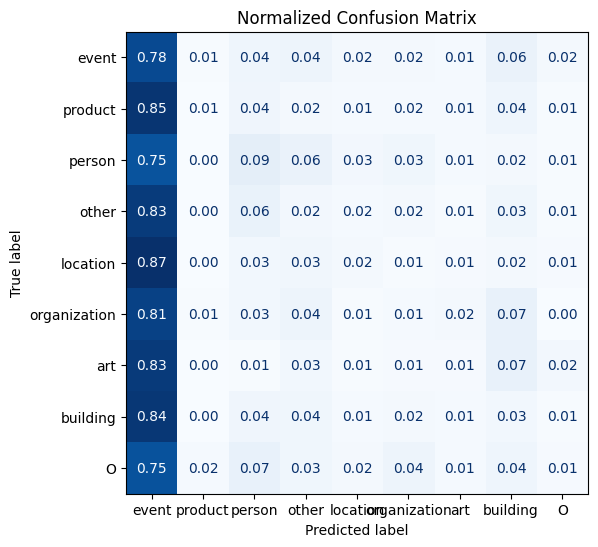

In [25]:
eval_token_list = list(set(eval_df_tokens['labels']))

plot_confusion_matrix(eval_df_tokens["labels"], eval_df_tokens["predicted_label"],
                      eval_token_list)

### Notes & Other Takeaways From This Project

****
-

****

### Citations

- Dataset

    > @inproceedings{ding-etal-2021-nerd,
    title = "Few-{NERD}: A Few-shot Named Entity Recognition Dataset",
    author = "Ding, Ning and Xu, Guangwei and Chen, Yulin and Wang, Xiaobin and Han, Xu and Xie, Pengjun and Zheng, Haitao and Liu, Zhiyuan", booktitle = "Proceedings of the 59th Annual Meeting of the Association for Computational Linguistics and the 11th International Joint Conference on Natural Language Processing (Volume 1: Long Papers)", month = aug, year = "2021", address = "Online", publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/2021.acl-long.248", doi = "10.18653/v1/2021.acl-long.248", pages = "3198--3213",}

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Metric (SeqEval)

    > @inproceedings{ramshaw-marcus-1995-text, title = "Text Chunking using Transformation-Based Learning", author = "Ramshaw, Lance and Marcus, Mitch", booktitle = "Third Workshop on Very Large Corpora", year = "1995", url = "https://www.aclweb.org/anthology/W95-0107",}
    
    > @misc{seqeval, title={{seqeval}: A Python framework for sequence labeling evaluation}, url={https://github.com/chakki-works/seqeval}, note={Software available from https://github.com/chakki-works/seqeval}, author={Hiroki Nakayama}, year={2018},}